In [193]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import pandas as pd
import fileinput
import re

from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error
import ipywidgets as widgets
from ipywidgets import interact, IntRangeSlider, Layout, fixed

# Data Transformation and Features Engineering Section

In [4]:
train_file_path = "Data/PM_train.txt"
test_file_path = "Data/PM_test.txt"
colnames = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7",
           "s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

In [5]:
def move_col_last(df,col_name):
  return pd.concat([df.drop(col_name,axis=1),df[col_name]], axis=1)

def move_col_first(df,col_name):
  return pd.concat([df[col_name],df.drop(col_name,axis=1)], axis=1)

def sort_dict(d):
  return dict(sorted(d.items(), key=lambda x: x[1]))

In [137]:
def transfer_data(file_path,col_names,features=[],shuffle=False):
  # user defined variables to set the windows for classifcation
  w1 = 30
  w0 = 15
  # window size (window_size>=2),  most recent sensor values
  window_size = 5
  
  # read in the file
  with open(file_path, 'r') as f:
    filedata = f.read()
  
  # remove white space from the end of line
  filedata = re.sub('\s*$', '',filedata,flags = re.M)
  
  # filedata is a string that pretends to be a file input
  file_as_string = StringIO(filedata)

  dataset = pd.read_table(file_as_string,sep=" ",names=colnames)
  
  # get the maximum cycle number for each id
  d1 = dataset.groupby(["id"])["cycle"].max().to_frame()
  d1.columns = ['max']
  
  ds_diff = dataset.groupby(["id"])["s1"].diff(-1).to_frame()
  #df["dA"] = df["A"].diff(-1)

  # add column with the name 'id' (just copy the index)
  d1['id'] = d1.index
  d2 = pd.merge(dataset, d1, on='id')
  
  # generate the column RUL based on the values of columns "max" and "cycle"
  d2['RUL'] = d2['max'] - d2['cycle']

  # exclude column "max" from the data frame
  d2 = d2.drop('max', 1)

  # genearte label1 and label2
  dataset = d2
  dataset['label1'] = np.where(d2['RUL'] <= w1, 1, 0)
  dataset['label2'] = np.where(d2['RUL'] <= w0, 2, (np.where(d2['RUL'] <= w1,1,0)))
  
  # exclude comuns id, cycle, setting1,setting2,setting3, and last 3 columns
  # only the 21 sensor columns are kept in the data frame
  n_pre_sensor_columns = 5 # id, cycle, setting1,setting2,setting3
  n_after_sensor_columns = 3 #RUL, label1, label2
  n_col = len(dataset.columns)

  data = dataset[dataset.columns[n_pre_sensor_columns:n_col - n_after_sensor_columns]]
  n_sensor=len(data.columns)

  ids = dataset.id.unique()
  n_id = len(ids) # 100

  a = ["avg" + str(i) for i in range(1,n_sensor+1)] # average
  sd = ["std" + str(i) for i in range(1,n_sensor+1)] # standard deviation
  diffA = ["diffA" + str(i) for i in range(1,n_sensor+1)] # diff
  diffB = ["diffB" + str(i) for i in range(1,n_sensor+1)] # diff
  diffC = ["diffC" + str(i) for i in range(1,n_sensor+1)] # diff
  
  df = None
  subsets = []
  subset_rolling_mean = pd.DataFrame()
  subset_rolling_std = pd.DataFrame()
  subset_rolling_diffA = pd.DataFrame()
  subset_rolling_diffB = pd.DataFrame()
  subset_rolling_diffC = pd.DataFrame()
  for i in range(1,n_id+1):
    # get the subset of the data that only contains the sensor columns for the id i
    if 'avg' in features:
      subset_rolling_mean = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).mean()
      subset_rolling_mean.columns = a
      subsets.append(subset_rolling_mean)
    if 'std' in features:
      subset_rolling_std = data[dataset.id==i].rolling(window_size,axis=0,min_periods=1).std().fillna(0)
      subset_rolling_std.columns = sd
    if 'diffA' in features:
      subset_rolling_diffA = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffA.columns = diffA
    if 'diffB' in features:
      subset_rolling_diffB = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffB.columns = diffB
    if 'diffC' in features:
      subset_rolling_diffC = data[dataset.id==i].diff(1).fillna(0)
      subset_rolling_diffC.columns = diffC

    subset = pd.concat([subset_rolling_mean,subset_rolling_std,subset_rolling_diffA,subset_rolling_diffB,subset_rolling_diffC], axis=1)
    df_tmp = pd.concat([dataset[dataset.id == i],subset], axis=1)
    df_tmp = move_col_last(df_tmp,['RUL', 'label1','label2'])

    if df is None:
      df = df_tmp
    else:
      df = df.append(df_tmp,ignore_index=True)

  
  if (shuffle):
    df = df.sample(frac=1)
                          
  # Exclude column names: 'id','RUL','label1','label2'
  X = df.drop(['id','RUL','label1','label2'], 1)
  y = df['RUL']
  
  scaler = MinMaxScaler()
  X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)


  # Delete all columns that contain only zeros
  # X = X.loc[:, (df != 0).any(axis=0)]
  # X = X.dropna(axis=1)

  return X,y.as_matrix()

In [173]:
X0, y0 = transfer_data(train_file_path,colnames,features=['avg','std'],shuffle=True)
Xt0, yt0 = transfer_data(test_file_path,colnames,features=['avg','std'],shuffle=False)

In [174]:
X1, y1 = transfer_data(train_file_path,colnames,features=[],shuffle=True)
Xt1, yt1 = transfer_data(test_file_path,colnames,features=[],shuffle=False)

In [175]:
X2, y2 = transfer_data(train_file_path,colnames,features=['avg','std','diffA','diffB','diffC'],shuffle=True)
Xt2, yt2 = transfer_data(test_file_path,colnames,features=['avg','std','diffA','diffB','diffC'],shuffle=False)

In [176]:
X3, y3 = transfer_data(train_file_path,colnames,features=['diffA','diffB','diffC'],shuffle=True)
Xt3, yt3 = transfer_data(test_file_path,colnames,features=['diffA','diffB','diffC'],shuffle=False)

# Training section

## X0, y0

In [177]:
from sklearn import neural_network
NeuralNetwork_regr0 = neural_network.MLPRegressor(alpha=.1,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
NeuralNetwork_regr0.fit(X0,y0)
None

## X1, y1

In [178]:
from sklearn.tree import DecisionTreeRegressor
DecisionTree_regr1 = DecisionTreeRegressor(max_leaf_nodes=2000,max_depth=32)
DecisionTree_regr1.fit(X1,y1)
None

In [179]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
Bagging_regr1 = BaggingRegressor(DecisionTreeRegressor(max_depth=32,min_samples_split=128),n_estimators=8)
Bagging_regr1.fit(X1,y1)
None

In [180]:
from sklearn import linear_model
Lasso_regr1 = linear_model.Lasso(alpha =.1)
Lasso_regr1.fit(X1,y1)
None

In [181]:
from sklearn import neural_network
NeuralNetwork_regr1 = neural_network.MLPRegressor(alpha=.1,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
NeuralNetwork_regr1.fit(X1,y1)
None

## X2, y2

In [182]:
from sklearn.tree import DecisionTreeRegressor
DecisionTree_regr2 = DecisionTreeRegressor(max_leaf_nodes=2000,max_depth=32)
DecisionTree_regr2.fit(X2,y2)
None

In [183]:
from sklearn import linear_model
Lasso_regr2 = linear_model.Lasso(alpha =.1)
Lasso_regr2.fit(X2,y2)
None

In [184]:
from sklearn import neural_network
NeuralNetwork_regr2 = neural_network.MLPRegressor(alpha=.09,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
NeuralNetwork_regr2.fit(X2,y2)
None

## X3, y3

In [185]:
from sklearn.tree import DecisionTreeRegressor
DecisionTree_regr3 = DecisionTreeRegressor(max_leaf_nodes=2000,max_depth=32)
DecisionTree_regr3.fit(X3,y3)
None

In [186]:
from sklearn import linear_model
Lasso_regr3 = linear_model.Lasso(alpha =.1)
Lasso_regr3.fit(X3,y3)
None

In [187]:
from sklearn import neural_network
NeuralNetwork_regr3 = neural_network.MLPRegressor(alpha=.09,max_iter=400,hidden_layer_sizes=(50,),solver='lbfgs',random_state=1)
NeuralNetwork_regr3.fit(X3,y3)

MLPRegressor(activation='relu', alpha=0.09, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# Charts  Section

## Charting functions

In [168]:
RangeSlider = widgets.IntRangeSlider(
    value=[8311,8391],
    min=1,
    max=len(Xt0),
    step=10,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    height=3,
    layout=Layout(width='90%', height='50px'),
)

def scaler(arr):
  scaler = MinMaxScaler()
  return pd.DataFrame(scaler.fit_transform(pd.DataFrame(arr)))

def Y_ploter(Range,Y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(16,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Y)))

  for y,color in zip(Y.items(),colors):
    plt.scatter(np.arange(start, end, 1),y[1][start:end], c=color, s=30/(range_len/80),alpha=0.5, label=y[0])

  plt.grid()
  plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("GT Cycles and Predicted Cycles")
  plt.title(" vs ".join([s for s in Y.keys()]))
  lgnd = plt.legend(scatterpoints=1, fontsize=14)
  for handle in lgnd.legendHandles:
    handle.set_sizes([30])
  plt.show()

def general_data_ploter(Range,Xs,y,scale_y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(13,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Xs)))
  
  for X,color in zip(Xs,colors):
    # Get label
    label = pd.DataFrame(X).columns[0]
    if(label == 0):
      label = 'y'
    plt.scatter(np.arange(start, end, 1),X[start:end], c=color, s=30/(range_len/80),alpha=0.5, label=label)

  if(scale_y):
    y = scaler(y)

  plt.grid()
  plt.xlabel("%s data points\n range [%s:%s]" % (end-start,start,end))
  plt.ylabel("Cycles and sensors values (Scalled)")
  plt.title("Scalled Data and Cycles")
  lgnd = plt.legend(scatterpoints=1, fontsize=14)
  for handle in lgnd.legendHandles:
    handle.set_sizes([30])
  plt.show()
  
def bar_chart(scores,title):
  plt.figure(figsize=(13,5))
  values = np.array(list(scores.values()))
  keys = list(scores.keys())
  colors = cm.rainbow(np.linspace(0, 1, len(scores)))
  plt.bar(range(len(scores)), values, align='center',color=cm.rainbow(np.linspace(0, 1, len(scores))))
  plt.xticks(range(len(scores)), keys,rotation=45)
  plt.title(title)
  plt.figure()

## Scores

In [188]:
scores = {
  "GT":1,
  #"Decision Tree avg std": DecisionTree_regr1.score(Xt1,yt1),
  #"Decision Tree diff": DecisionTree_regr2.score(Xt2,yt2),
  #"Bagging avg std": Bagging_regr1.score(Xt1,yt1),
  #"Lasso avg std": Lasso_regr1.score(Xt1,yt1),
  #"Lasso diff": Lasso_regr2.score(Xt2,yt2),
  "NeuralNetwork none": NeuralNetwork_regr0.score(Xt0,yt0),
  "NeuralNetwork avg std": NeuralNetwork_regr1.score(Xt1,yt1),
  "NeuralNetwork avg std diff": NeuralNetwork_regr2.score(Xt2,yt2),
  "NeuralNetwork diff": NeuralNetwork_regr3.score(Xt3,yt3),
}

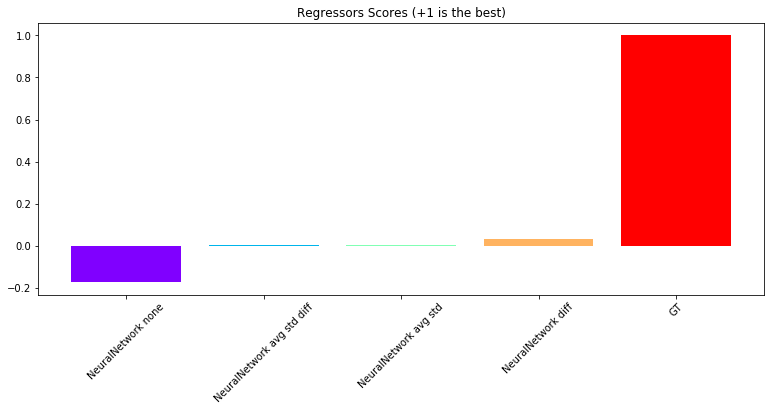

In [189]:
bar_chart(sort_dict(scores),"Regressors Scores (+1 is the best)")

## mean_squared_error

NeuralNetwork none: 0.0987861237359
NeuralNetwork avg std: 0.173318086737
NeuralNetwork avg std diff: 0.177670699315
NeuralNetwork diff: 0.18890698464


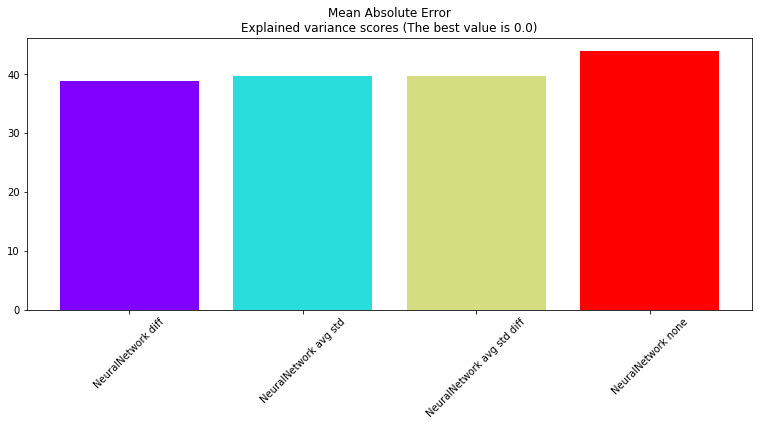

In [210]:
Y = {
  #"DecisionTree": DecisionTree_regr1.predict(Xt),
  #"DecisionTree2": DecisionTree_regr2.predict(Xt2),
  #"Bagging": Bagging_regr1.predict(Xt),
  #"Lasso": Lasso_regr1.predict(Xt),
  #"Lasso2": Lasso_regr2.predict(Xt2),
  "NeuralNetwork none": NeuralNetwork_regr0.predict(Xt0),
  "NeuralNetwork avg std": NeuralNetwork_regr1.predict(Xt1),
  "NeuralNetwork avg std diff": NeuralNetwork_regr2.predict(Xt2),
  "NeuralNetwork diff": NeuralNetwork_regr3.predict(Xt3),
}

scores = {}
for label,y_pred in Y.items():
  print("%s: %s" % (label,explained_variance_score(yt3,y_pred)))
  scores[label] = mean_absolute_error(yt3,y_pred)
  
bar_chart(sort_dict(scores),"Mean Absolute Error\nExplained variance scores (The best value is 0.0)")

In [192]:
interact(Y_ploter,Range=RangeSlider,Y=fixed(Y))
None

interactive(children=(IntRangeSlider(value=(8311, 8391), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

In [204]:
Xs = [scaler(yt1),
      #X['s3'],X['a3'],X['sd3'],
      Xt1['s3'],
      Xt1['s4'],
      Xt1['s7'],
      Xt1['s8'],
      Xt1['s9'],
      Xt1['s11'],
      Xt1['s12'],
      Xt1['s13'],
      Xt1['s14'],
      Xt1['s17'],
      Xt1['s20'],
     ]

interact(general_data_ploter,Range=RangeSlider,Xs=fixed(Xs),y=fixed(yt1),scale_y=fixed(True))
None

interactive(children=(IntRangeSlider(value=(8591, 9141), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

In [205]:
Xs = [scaler(yt1),
      #X['s3'],X['a3'],X['sd3'],
      X1['s3'],
      X1['s4'],
      X1['s7'],
      X1['s8'],
      X1['s9'],
      X1['s11'],
      X1['s12'],
      X1['s13'],
      X1['s14'],
      X1['s17'],
      X1['s20'],
     ]

interact(general_data_ploter,Range=RangeSlider,Xs=fixed(Xs),y=fixed(yt1),scale_y=fixed(True))
None

interactive(children=(IntRangeSlider(value=(8591, 9141), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

In [207]:
def cycle_vs_sensors(Range,Xs,y,scale_y):
  start, end = Range
  range_len = end-start
  
  plt.figure(figsize=(13,10))
  
  # pick colors
  colors = cm.rainbow(np.linspace(0, 1, len(Xs)))
  
  for X,color in zip(Xs,colors):
    label = pd.DataFrame(X).columns[1]  # Get label
    plt.scatter(X.iloc[:, 1][start:end],X.iloc[:, 0][start:end], c=color, s=30/(range_len/80),alpha=0.5, label=label)

  if(scale_y):
    y = scaler(y)

  plt.grid()
  plt.ylabel("Cycles (Scalled)")
  plt.xlabel("Sensors value (Scalled)")
  plt.title("%s data points\n range [%s:%s]" % (end-start,start,end))
  lgnd = plt.legend(scatterpoints=1, fontsize=14)
  for handle in lgnd.legendHandles:
    handle.set_sizes([30])
  plt.show()
  
Xs = [#X1[['cycle','s3']],
      #X1[['cycle','s4']],
      #X1[['cycle','s7']],
      #X1[['cycle','s8']],
      #X1[['cycle','s9']],
      #X1[['cycle','s11']],
      #X1[['cycle','s12']],
      #X1[['cycle','s13']],
      X1[['cycle','s14']],
      X1[['cycle','s17']],
      X1[['cycle','s20']],]

interact(cycle_vs_sensors,Range=RangeSlider,Xs=fixed(Xs),y=fixed(yt1),scale_y=fixed(True))

interactive(children=(IntRangeSlider(value=(1, 13091), continuous_update=False, description='Test:', layout=Layout(height='50px', width='90%'), max=13096, min=1, step=10), Output()), _dom_classes=('widget-interact',))

<function __main__.cycle_vs_sensors>